# TAOS0 drifter deployments: schedule route for drifter deployments


In [2]:
import os
from glob import glob

from datetime import datetime
from time import sleep

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import pyproj

import taos.utils as ut
import taos.insitu as ins
from taos.insitu import rad2deg, knot, _lonc, _latc
lonc, latc  = _lonc, _latc

---

## useful metrics

In [3]:
ins.metrics_cheatsheet(lonc, latc)

 lon: 1 deg = 72.44km,  0.1 deg = 7.2km,  0.01 deg = 724.4m,  0.001 deg = 72.4m
 lon: 1 deg = 72.44km,  1 min = 1207.3m,  .1 min = 120.7m,  0.01 min = 12.1m
 lon: 1 deg = 72.44km,  1 sec = 20.1m,  .1 sec = 2.0m
-----------------------------------------------------------------
 lat: 1 deg = 111.23km,  0.1 deg = 11.1km,  0.01 deg = 1112.2m,  0.001 deg = 111.2m
 lat: 1 deg = 111.23km,  1 min = 1853.7m,  .1 min = 185.4m,  0.01 min = 18.5m
 lat: 1 deg = 111.23km,  1 sec = 30.9m,  .1 sec = 3.1m


🐷🐷🐷🐷🐨🌼🌼🌼💐💐🌾🌖🌾😋😋👩‍🦳👩‍🦳§😄😁😁😁😀😄😄(😃😄(😚😚😗)🙃😇😇😇😇🥳🥳😏🥳🥳😏🥳😏🥳)😡😡😡😡😡😡👹👹👹👺👺👺👾👽👾😿😿😿😸😹👍🖐🏻👉🏽👀👥👥👥👥👥👥👥🧑🏽‍🦰🧑🏽‍🦰👱‍♂️👱‍♂️👱‍♂️👱‍♂️😡🤕à🤕🤕🤒😷

---

## drifter deployment route

In [4]:
theta = 0/rad2deg

In [5]:
# deployment geometry
#R, theta, N = 1e3, 0/rad2deg, 5
R, N = 1e3, 5
anchor = ins.stations.loc["LSTOuistreham"]
lon_a, lat_a = anchor["lon"], anchor["lat"]
center_loc = 2

# other variables
speed = 10 # knots
time_waiting = 7*60 # seconds

#lon, lat, X = ins.build_square_geo(lon_a, lat_a, R, theta, rotation=-1, center_loc=center_loc)
x_a, y_a = ins.ll2xy(lon_a, lat_a)
X, _ = ins.build_polygon(R, theta, 3, rotation=1)
X = X - X[0]
x, y = x_a+X.real, y_a+X.imag
lon, lat = ins.xy2ll(x, y)

In [6]:
lon, lat

(array([-0.246754  , -0.26737372, -0.2674156 ]),
 array([49.340379  , 49.3481914 , 49.33261772]))

```
ship position: -0.0W 14.805  49.0N 20.423 at 2022/11/30 16:00:15
drifter 0: -0.0W 14.809  49.0N 20.424 at 2022/11/30 16:05:16
drifter 1: -0.0W 16.089  49.0N 20.886 at 2022/11/30 16:16:00
drifter 2: -0.0W 16.134  49.0N 19.944 at 2022/11/30 16:26:40
````

In [7]:
# first in water: 4351896 @ 15:42

# first water: 
# drifter 0: 4351 1896
# drifter 1: 4351 0125
# drifter 1: 4351 2044
dash = ins.dashboard_route(lon, lat, ship_speed=speed, time_waiting=time_waiting/60)
dash.grid

Output()

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


GridspecLayout(children=(Button(description='Update', icon='check', layout=Layout(grid_area='widget001'), styl…

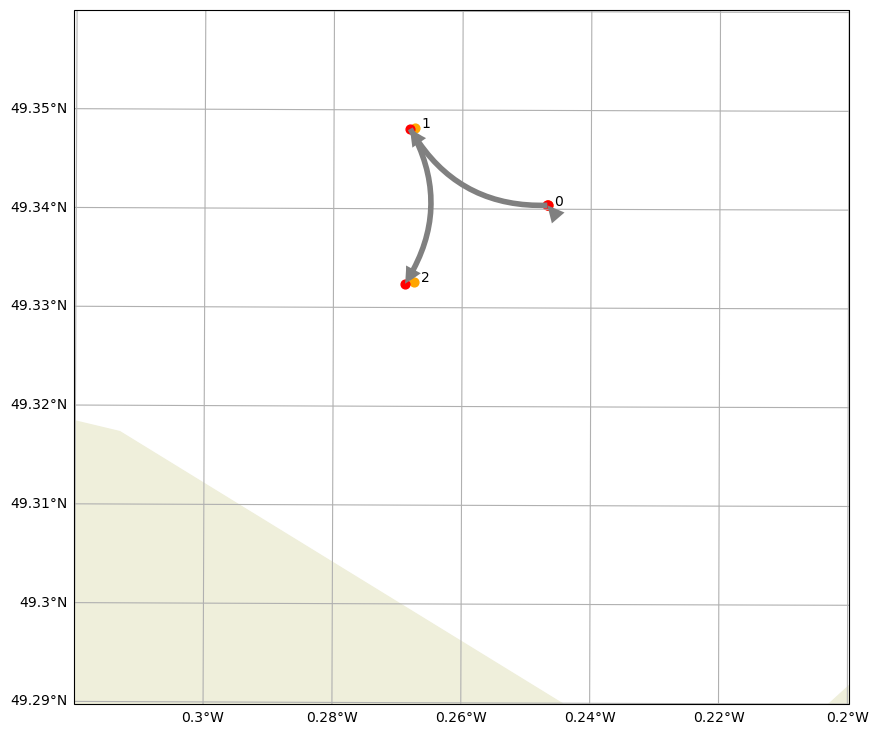

In [8]:
ins.plot_deployments_route(dash.lon_vertices, dash.lat_vertices, dash.df, 
                           bathy=False, land=dict(scale="10m"), coast_resolution=None,
                          );

### Extract current speed and direction from dashboard

In [7]:
U = dash.w["current_speed_x"].value + 1j*dash.w["current_speed_y"].value
#U = 1. + 1j*1. # dev
U_theta = np.angle(U)
U_amplitude = np.abs(U)
print(f" theta={U_theta:.2f} rad = {U_theta*rad2deg:.2f} deg, abs(U) = {U_amplitude:.2f} m/s")

 theta=-0.31 rad = -17.88 deg, abs(U) = 0.65 m/s


In [8]:
# set rotation angle to current direction
theta = U_theta

---

## underway ctd: lazy sampling

In [9]:
speed_ship = 4 # knots
L = R*2.5 # section length

# time to reach section center
dt = L/2 /speed_ship/ins.knot
Xc = R*U/np.abs(U) + U*dt

# compute start/end positions
X_start = Xc + L/2*U*np.exp(1j*np.pi/2)/np.abs(U)
X_end = Xc - L/2*U*np.exp(1j*np.pi/2)/np.abs(U)

# back to geographical coordinates
#x_a, y_a = ins.ll2xy(lon_a, lat_a)
x_c, y_c = ins.ll2xy(lon[center_loc], lat[center_loc])
lon_start, lat_start = ins.xy2ll(x_c+X_start.real, y_c+X_start.imag)
lon_end, lat_end = ins.xy2ll(x_c+X_end.real, y_c+X_end.imag)

i=0
for _lon, _lat in zip([lon_start, lon_end], [lat_start, lat_end]):
    _lon_deg, _lon_min = ins.deg_mindec(_lon)
    _lat_deg, _lat_min = ins.deg_mindec(_lat)
    if _lon_deg<=0:
        EW="W"
    else:
        EW="E"
    print(f"Point {i}: {_lon_deg}{EW} {_lon_min:.3f}  {_lat_deg}N {_lat_min:.3f}")
    i+=1

Point 0: -0.0W 14.216  49.0N 20.833
Point 1: -0.0W 14.853  49.0N 19.550


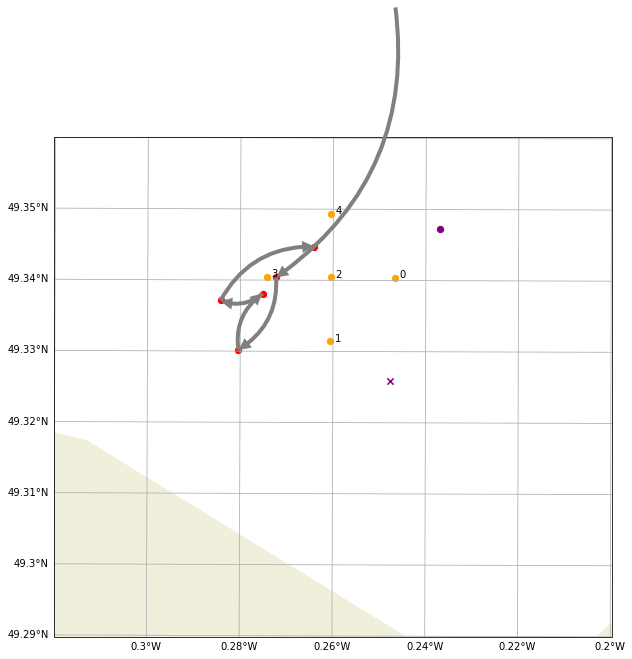

In [10]:
fac = ins.plot_deployments_route(dash.lon_vertices, dash.lat_vertices, dash.df, 
                                 bathy=False, land=dict(scale="10m"), coast_resolution=None,
                                )

ax = fac["ax"]
crs = ins.ccrs.PlateCarree()

ax.scatter(lon_start, lat_start, 40, color="purple", marker="o", transform=crs)
ax.scatter(lon_end, lat_end, 40, color="purple", marker="x", transform=crs)

---

## underway ctd: radiator sampling

In [12]:
# find the square center
lonc, latc = lon[center_loc], lat[center_loc]

# radiator properties
R_radiator, N = 2.5*R, 3

# build radiator
lon_radiator, lat_radiator, length_radiator, dX_radiator = ins.radiator(R_radiator, N, theta, lonc, latc)

# underway sampling is slower
speed_radiator = 4

(0.7071067811865476+0.7071067811865476j)
Distance 7.63614234542708 NM


In [13]:
dash_ctd = ins.dashboard_route(lon_radiator, lat_radiator, 
                               ship_speed=speed_radiator,
                               current_speed_x=U.real, current_speed_y=U.imag,
                               time_waiting=1,
                              )
dash_ctd.grid

Output()

/Users/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


GridspecLayout(children=(Button(description='Update', icon='check', layout=Layout(grid_area='widget001'), styl…

{'fig': <Figure size 720x720 with 1 Axes>,
 'ax': <GeoAxesSubplot:>,
 'cbar': None}

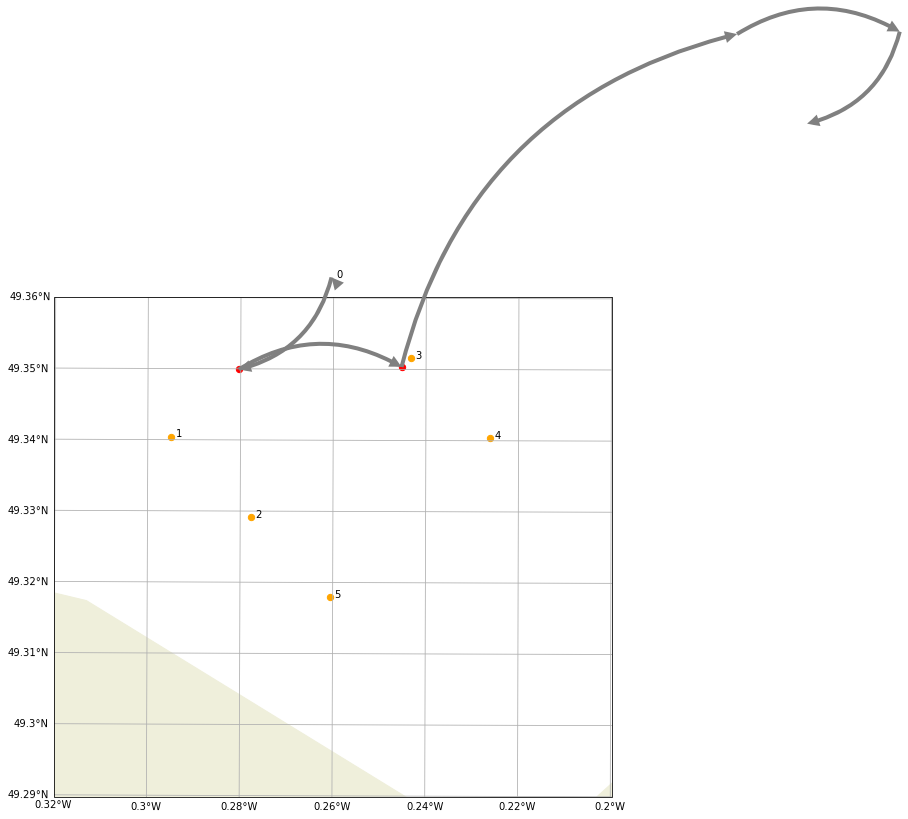

In [14]:
ins.plot_deployments_route(dash_ctd.lon_vertices, dash_ctd.lat_vertices, dash_ctd.df, 
                           bathy=False, land=dict(scale="10m"), coast_resolution=None,
                          )

⛷⛷⛷⛷⛹️‍♂️🛹🥌🥶🥶🎽
😀😀😔😔🥳🥳🥳🥳
🤩😞
😨🥵🤬⚽️🏀🏈⚾️🥎🎾🎾🏐🥏
